## Notebook reproducing analysis experiments in section 4.1 of the paper

### Imports

In [ ]:
from models.model import CNN
from sklearn import svm
from sklearn.multiclass import OneVsRestClassifier
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm
from utils.CKA import CudaCKA
from estimators.FM import FM,FM_distfunc,FM_T
from utils.fmap import build_graph
import numpy as np
from estimators.FM import FM,FM_distfunc,FM_T
from utils.CKA import linear_CKA, kernel_CKA
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import os
import random
import numpy as np





### Reproduce analysis experiment in section 4.1 of the paper


In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
N = 10000  # Number of samples from the test set to use
path = "../data/model_weights/"
models = []
cka=CudaCKA("cuda")
# Load models
for f in [os.listdir(path)[0]]:
    model = CNN(num_classes=10).to(device)
    model.load_state_dict(torch.load(os.path.join(path, f)))
    models.append(model)


train_dataset = datasets.CIFAR10('../data', train=True, download=True)




mean,std=train_dataset.data.mean((0,1,2))/255,train_dataset.data.std((0,1,2))/255
#meant,stdt= test_dataset.data.astype('float32').mean()/255,test_dataset.data.astype('float32').std()/255

print(mean,std)
# Data loaders
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std)
])
test_dataset = datasets.CIFAR10('../data', train=True, transform=transform,download=True)
test_loader = DataLoader(test_dataset, batch_size=N, shuffle=False)
test_samples, ll = next(iter(test_loader))
test_samples = test_samples.to(device)

# Initialize similarity matrix
similarity_matrices_fmap = []
similarity_matrices_cka = []
similarity_matrices_conformal=[]
similarity_matrices_distortion=[]
layer_indices=list(range(8))+['avg']
# Extract activations and compute similaritie
num_pert=25
similarity_matrix_cka = np.zeros((num_pert))
similarity_matrix_fmap = np.zeros((num_pert))
similarity_matrix_distortion = np.zeros((num_pert))
similarity_matrix_conformal = np.zeros((num_pert))


activations_list = model.get_activations(test_samples, ['avg'])
x=activations_list[-1].reshape(N,-1).cpu()


# Standardize the features
#scaler = StandardScaler()
#X_scaled = scaler.fit_transform(X)

# Train the One-vs-Rest SVM
svmm = OneVsRestClassifier(svm.SVC(kernel='linear'))
svmm.fit(x.detach().cpu(), ll.detach().cpu())

weights = svmm.estimators_[0].coef_
intercepts = svmm.estimators_[0].intercept_

for i, clf in enumerate(svmm.estimators_):
    print(f"Classifier for class {i}:")
    print(f"Weights: {clf.coef_}")
    print(f"Intercept: {clf.intercept_}")
    print()

# Function to translate a sample in the direction of the hyperplane
def translate_sample(sample, class_index, distance=1.0,mask=None):
    weight = svmm.estimators_[class_index].coef_[0]
    norm = np.linalg.norm(weight)
    direction = weight / norm
    return sample + mask*(distance * direction)

# Example: Translate samples from class 0
p=torch.zeros(x.shape[0],1)
p[ll==0]=1
matrices_dist=[]
distances=np.linspace(0,80,num_pert)
for i,k in enumerate(distances):
    model.eval()
    with torch.no_grad():
        y = translate_sample((x).detach().cpu(), 0,distance=k,mask=p).float()
        similarity_matrix_cka[i] =cka.linear_CKA(x.cuda(),y.cuda())
        fmap=FM_T(x,y,[],num_eigs=50,graph_algo='knn',graph_similarity='angular',graph_kernel='distance',descriptors=('HKS',),k=300,n_descr=10,compute_gt_map=True,compute_measures=True)
        similarity_matrix_fmap[i] = fmap.get_similarity()
        da=fmap.get_similarity(fmap.CA)
        matrices_dist.append(fmap.CA)
        dc=fmap.get_similarity(fmap.CO)
        similarity_matrix_distortion[i]=da
        similarity_matrix_conformal[i]=dc

### Plot results



/tmp/ipykernel_711461/513799551.py:12: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = mpl.colors.ListedColormap(plt.cm.get_cmap("Set1", 10).colors[:10], name="rgb", N=10)


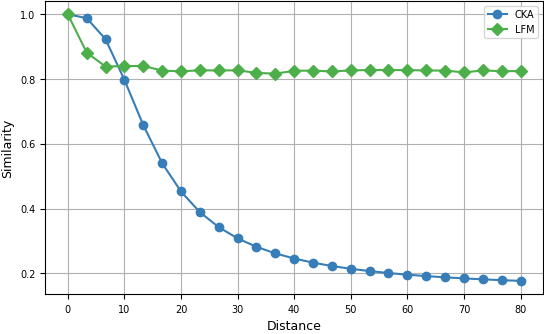

In [ ]:
from tueplots import bundles
from tueplots import figsizes, fontsizes
import matplotlib as mpl
import matplotlib.pyplot as plt

bundle = bundles.neurips2023()
# plt.rcParams.update(bundle)
plt.rcParams.update(fontsizes.neurips2023(), )

bundle = bundles.neurips2023(family="sans-serif", usetex=False, nrows=1)
with plt.rc_context(bundle):
    # Get the first color from the Set1 colormap
    #cmap = plt.get_cmap("")
    cmap = mpl.colors.ListedColormap(plt.cm.get_cmap("Set1", 10).colors[:10], name="rgb", N=10)

    #color1 = cmap(0)
    
    plt.plot(distances, similarity_matrix_cka, marker='o',color=cmap(1))
    plt.plot(distances, similarity_matrix_distortion, marker='D',color=cmap(2))

    #plt.plot(distances, similarity_matrix_fmap, marker='o', color=cmap(2))
    #plt.plot(distances, similarity_matrix_conformal, marker='o', color=cmap(3))
    
    plt.grid()

    plt.xlabel('Distance')
    plt.ylabel('Similarity')

    #plt.legend(['CKA','Fmap_distortion','Fmap_ratio','Fmap_conformal'])
    plt.legend([ 'CKA','LFM'])
    #plt.savefig('plot_results/ckavslfm.pdf', dpi=300, bbox_inches='tight')

    plt.show()

/tmp/ipykernel_711461/3339684341.py:21: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = mpl.colors.ListedColormap(plt.cm.get_cmap("tab10", 10).colors[:max(ll)+1], name="rgb", N=max(ll)+1)


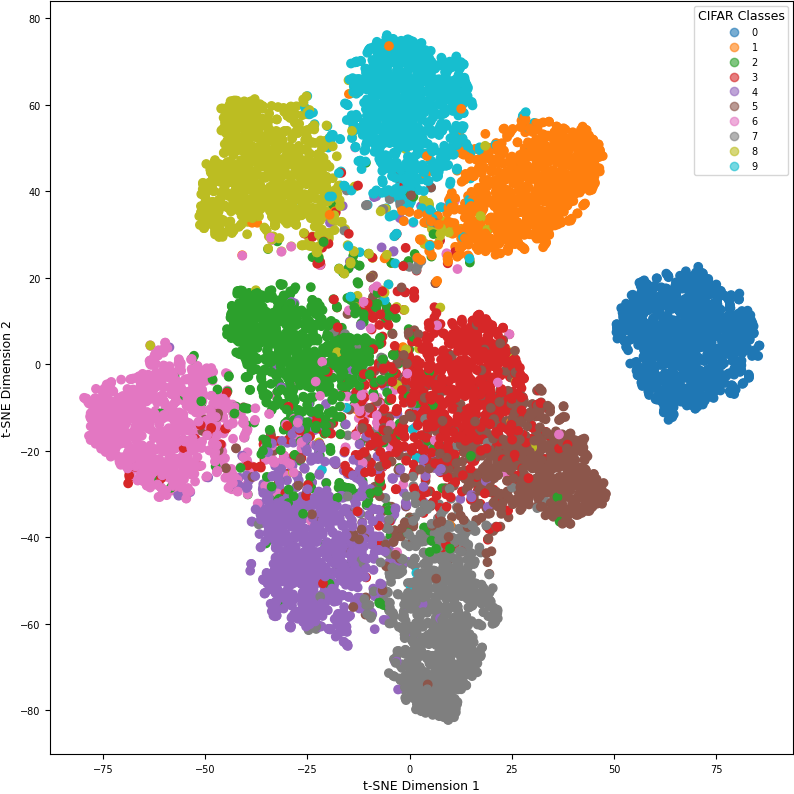

In [14]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import tueplots
from tueplots import bundles
from tueplots import figsizes, fontsizes
import matplotlib as mpl

bundle = bundles.neurips2023()
# plt.rcParams.update(bundle)
plt.rcParams.update(fontsizes.neurips2023(), )


C=torch.from_numpy(fmap.eigvecs2.T@fmap.eigvecs1)


U,S,V=torch.svd(C.double())
res=fmap.eigvecs2@U.numpy()[:,-1]

norm = plt.Normalize(min(ll), max(ll))
cmap = mpl.colors.ListedColormap(plt.cm.get_cmap("tab10", 10).colors[:max(ll)+1], name="rgb", N=max(ll)+1)


# Generate some example data (e.g., 100 samples with 50 features)
np.random.seed(42)

# Apply the t-SNE algorithm to reduce dimensionality to 2D
tsne = TSNE(n_components=2, random_state=42)
data_2d = tsne.fit_transform(y)


bundle = bundles.neurips2023( family="sans-serif", usetex=False, nrows=1)
with plt.rc_context(bundle):

    # Apply the color function to each point
    #colors = np.apply_along_axis(color_function, 1, data)

    # Normalize colors to a range of 0 to 1 for colormap
    #norm_colors = (colors - np.min(colors)) / (np.max(colors) - np.min(colors))

    # Plot the 2D scatter plot
    plt.figure(figsize=(8, 8))
    scatter = plt.scatter(data_2d[:, 0], data_2d[:, 1], cmap=cmap,c=ll, norm=norm)
    plt.xlabel('t-SNE Dimension 1')
    plt.ylabel('t-SNE Dimension 2')
    handles, _ = scatter.legend_elements(prop="colors", alpha=0.6)
    labels=['0','1','2','3','4','5','6','7','8','9']
    legend_labels = labels
    
    plt.legend(handles, legend_labels, title="CIFAR Classes")
    #plt.savefig('plot_results/tsne_cifar10_.pdf', dpi=300, bbox_inches='tight')
    plt.show()

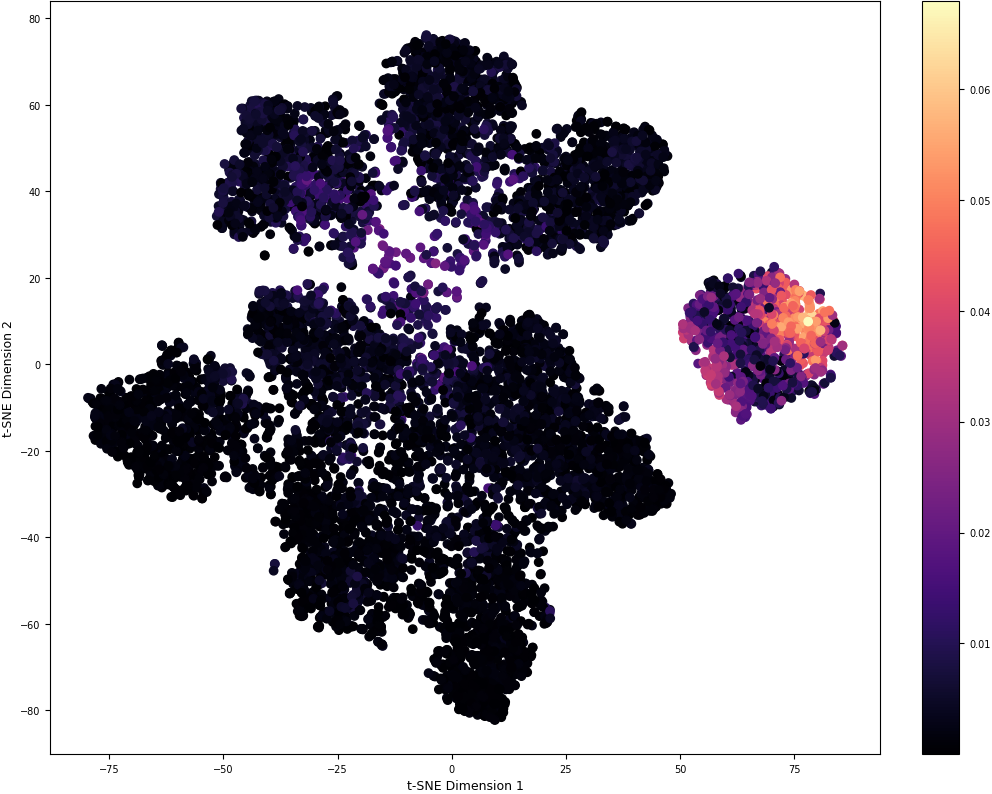

In [15]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

C=torch.from_numpy(fmap.eigvecs2.T@fmap.eigvecs1)


#U,S,V=torch.svd(C.double())
#res=fmap.eigvecs2@U.numpy()[:,-1]

# Generate some example data (e.g., 100 samples with 50 features)
np.random.seed(42)
bundle = bundles.neurips2023( family="sans-serif", usetex=False, nrows=1)
with plt.rc_context(bundle):


    # Apply the t-SNE algorithm to reduce dimensionality to 2D
    #tsne = TSNE(n_components=2, random_state=42)
    #data_2d = tsne.fit_transform(y)

    # Apply the color function to each point
    #colors = np.apply_along_axis(color_function, 1, data)

    # Normalize colors to a range of 0 to 1 for colormap
    #norm_colors = (colors - np.min(colors)) / (np.max(colors) - np.min(colors))

    # Plot the 2D scatter plot
    plt.figure(figsize=(10, 8))
    scatter = plt.scatter(data_2d[:, 0], data_2d[:, 1], c=np.abs(res), cmap='magma')
    plt.colorbar(scatter)
    #plt.title('Distortion of the map')
    plt.xlabel('t-SNE Dimension 1')
    plt.ylabel('t-SNE Dimension 2')
    #plt.savefig('plot_results/tsne_cifar10_distortion_.pdf', dpi=300, bbox_inches='tight')

    #plt.clim([0,0.12])
    plt.show()